### Comparison of predictive linear models for car prices using the used car dataset

In [22]:
import numpy as np
import pandas as pd
import math
import sklearn
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error

In [23]:
# read in data, pull out variables of interest and scale quantitative variables
cd = pd.read_csv("https://bitbucket.org/remcc/rob-data-sets/downloads/susedcars.csv")
cd = cd[['price','mileage','color']]
cd['price'] = cd['price']/1000
cd['mileage'] = cd['mileage']/1000
cd.head()

,price,mileage,color
0,43.995,36.858,Silver
1,44.995,46.883,Black
2,25.999,108.759,White
3,33.880,35.187,Black
4,34.895,48.153,Black


In [25]:
# create train and test splits based on 75%/25%
cdtr, cdte = train_test_split(cd,random_state=99, test_size=.25)
print('train dimension',cdtr.shape)
print('test dimension',cdte.shape)

train dimension (750, 3)
test dimension (250, 3)


In [26]:
# create dummy variables for color variable
one_hot = LabelBinarizer()
cdumtr = one_hot.fit_transform(cdtr['color'])
cdumte = one_hot.fit_transform(cdte['color'])
print(cdtr['color'][:10])
cdumtr[:10]

644     Black
389     Black
999     other
125     Black
792    Silver
464    Silver
676     other
606     White
319    Silver
466     Black
Name: color, dtype: object


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [43]:
# create train (Xctr) and test (Xcte) arrays for encoded color and mileage variables 
mlgtr = cdtr.iloc[:,[1]].to_numpy()
mlgte = cdte.iloc[:,[1]].to_numpy()
Xctr = np.concatenate([mlgtr, cdumtr[:,1:4]], axis=1)
Xcte = np.concatenate([mlgte, cdumte[:,1:4]], axis=1)


### Model and Predict using log transformation on price with mileage and color
- As asserted in the set-up for the homework, color did not appear to have an impact on price
- If color is truly indepdent of mileage, it is unlikely that adding it to the model would change the model estimates for price, but will confirm empirically 
- A log transformation of price was also asserted in the homework and shown to prevent negative prediction for price, this is further support by the skewed histogram of price

In [44]:
# check out distribution of price data
px.histogram(cd['price'], histnorm='probability density', marginal='box', nbins=30, width=700, height=450)

Text(0, 0.5, 'price')

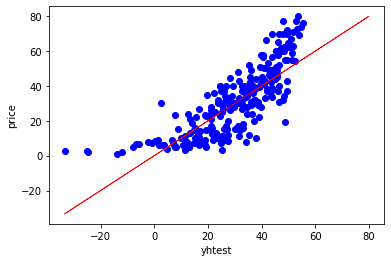

In [49]:
# Looking at the simple univariate predcitive linear model without transformation of Y
lml = LinearRegression(fit_intercept=True)
lml.fit(cdtr[['mileage']],cdtr['price'])

yhltest = lml.predict(cdte[['mileage']])

yy = np.concatenate([yhltest,cdte['price'].to_numpy()])
plt.plot(yy,yy,c='red',linewidth=.8)
plt.scatter(yhltest,cdte['price'],c='blue')
plt.xlabel('yhtest'); plt.ylabel('price')


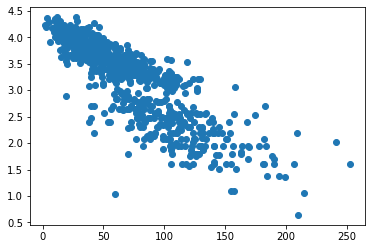

In [45]:
#log transform y to remove negative predicted prices
lprice = np.log(cdtr['price'])
plt.scatter(cdtr['mileage'],lprice)
plt.show()

- The lower scatter plot shows that negative prices have been removed with this transformation
- We will need to tranform back to the original data form for interpretation and analysis

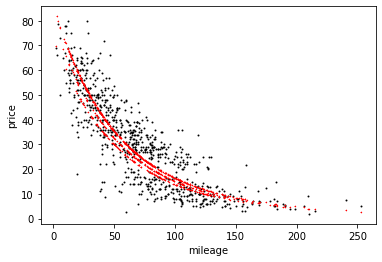

In [42]:
# run regression with log(Y) transformation, color and mileage
lm = LinearRegression(fit_intercept=True)
lm.fit(Xctr,lprice)
lyhtr = lm.predict(Xctr)
lyhte = lm.predict(Xcte)

yhatr = np.exp(lyhtr)
yhate = np.exp(lyhte)

#plot fitted model using training data
plt.scatter(cdtr['mileage'],cdtr['price'],marker='o',c='black',s=.9)
plt.scatter(cdtr['mileage'],yhatr,marker=5,c='red',s=.5)
plt.xlabel('mileage'); plt.ylabel('price')
plt.show()

- While the model seems like a reasonable fit for the data, color seems to just adjust the intercept for each color

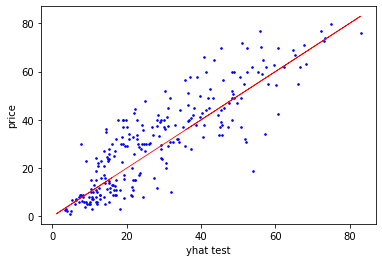

In [37]:
# plotted actual prices versus predicted values of price
yy = np.concatenate([yhate, cdte['price'].to_numpy()])
plt.plot(yy,yy,c='red',linewidth=.8)
plt.scatter(yhate,cdte['price'],c='blue',s=2.5)
plt.xlabel('yhat test'); plt.ylabel('price')
plt.show()


- A good predictive model should have a linear relationship between yhat (our estimated values for price, predicted on out of sample data) and Y (actual price)
- While the shape appears to be linear, there seems to be a siginificant amount of variance between them.  This can be analyzed numerically to interpret and confirm

In [39]:
# out of sample rmse for log(Y), quadratic model with color and mileage
rmse = math.sqrt(mean_squared_error(yhate,cdte['price']))
print(f'RMSE using log(Y), mileage, mileage squared and color is {rmse:0.2f}.')

RMSE using log(Y), mileage, mileage squared and color is 10.15.


- The RMSE for our predictive model is 10.15, which is approximately 10,150 dollars in price.  In context, that means that our predicted estimate for price will be within +/-10,150 dollars of the actual price.  Is this a reasonable tolerance for the price of a car, given the scale?  Probably not, since it is a relatively large proporation of the range for Y.
- We will compare with a quadratic model on untransformed Y

### Model and Predict using mileage, mileage squared, and color without log transformation of price(Y)
- As asserted in above (see histogram) there is R tailed skew in price, and predictions with mileage alone yielded negative price predictions
- We will compare our previous model performance with a new model that adds a quadratic term for mileage and removes the log transformation on Y
- Comparison will be made with RMSE and visualizations

In [54]:
# create train (Xc2tr) and test (Xc2te) arrays for encoded color and mileage, mileage squared variables 
mlgsqtr = mlgtr**2
mlgsqte = mlgte**2
Xc2tr = np.concatenate([mlgtr, mlgsqtr, cdumtr[:,1:4]], axis=1)
Xc2te = np.concatenate([mlgte, mlgsqte, cdumte[:,1:4]], axis=1)
Xc2tr[:,0:5]

array([[4.78940000e+01, 2.29383524e+03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.72950000e+01, 7.45017025e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.31121000e+02, 1.71927166e+04, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00],
       ...,
       [1.51939000e+02, 2.30854597e+04, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [8.06450000e+01, 6.50361602e+03, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00],
       [1.04118000e+02, 1.08405579e+04, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00]])

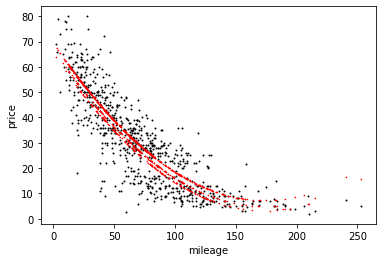

In [56]:
# run regression color and mileage and mileage sqaured
lm2 = LinearRegression(fit_intercept=True)
lm2.fit(Xc2tr,cdtr['price'])
yht2tr = lm2.predict(Xc2tr)
yht2te = lm2.predict(Xc2te)

#plot fitted model using training data
plt.scatter(cdtr['mileage'],cdtr['price'],marker='o',c='black',s=.9)
plt.scatter(cdtr['mileage'],yht2tr,marker=5,c='red',s=.5)
plt.xlabel('mileage'); plt.ylabel('price')
plt.show()

- Again color seems to just change the intercepts and not contribute anything meaningful
- The training model seems to reasonably represent the data, however there seems to be some significant amount of variance from 40,000 to 70,000

Text(0, 0.5, 'price')

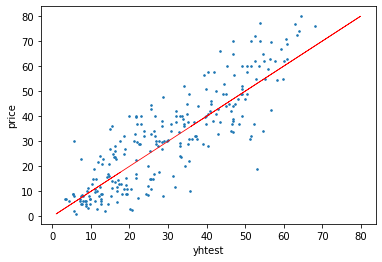

In [60]:
# compare out of sample predictions with actual values for price in our test set
yy = np.concatenate([yht2te, cdte['price'].to_numpy()])
plt.plot(yy,yy,c='red',linewidth=.8)
plt.scatter(yht2te, cdte['price'], s=2.5)
plt.xlabel('yhtest'); plt.ylabel('price')

- This seems to be quite similar to the previous model, with visually a little less variance
- The model is reassuring in the sense that it does not predict negative values for price
- We will need to examine the RMSE to see if there is an improvement in performance compared to the log transformed model above

In [62]:
# out of sample RMSE for quadratic model (untransformed Y)
rmse = math.sqrt(mean_squared_error(yht2te,cdte['price']))
print(f'RMSE using mileage, mileage squared and color is {rmse:0.2f}.')

RMSE using mileage, mileage squared and color is 9.97.


### Conclusion
- The quadratic model using mileage and color without the log transformation of Y is comparitively better for predicting the estimate of price for out of sample data.  This was validated with the RSME for both predictive models.  The improvement in RMSE is .18, or 1,800 dollars in price.  
- In context, there is a slgiht improvement in the confidence interval for our predicted price values in the model.  The better performing model can predict an estimated value for price within +/- 9,970 dollars.
- While it is a relatively small improvement, the range of values that our estimated price could take is still quite large in comparison to the range of price values we were using to develop the models.  Predicting the price of a used car at 30,000 rather than an acutal market price of 21,000 is a significant loss of profit for a seller. It would be prudent to explore different models with other predictors/transformations or different modeling methods.  